In [2]:
!pip install scikit-learn

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------------- ------------------- 4.2/8.1 MB 24.4 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 23.6 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 18.9 MB/s  0:00:00

   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   ------------

DATASET PARA MODELADO CLV
Clientes analizados: 200
CLV promedio: $1384
Rango CLV: $317 - $8112

CORRELACIONES CON CLV:
ingresos             | +0.940
frecuencia_compras   | +0.252
edad                 | +0.064
antiguedad_meses     | +0.063
satisfaccion         | -0.061

MODELO 1: CLV ~ INGRESOS
R²: 0.8840
RMSE: $258

MODELO 2: REGRESIÓN MÚLTIPLE
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -83.0423    110.407     -0.752      0.453    -300.788     134.704
ingresos               0.0202      0.000     44.420      0.000       0.019       0.021
frecuencia_compras    55.6135      8.058      6.901      0.000      39.721      71.506
antiguedad_meses       2.6863      0.670      4.010      0.000       1.365       4.008
satisfaccion          35.1456     13.308      2.641      0.009       8.900      61.391
R²: 0.9162
RMSE: $219
AIC: 2733.6

MEJORA RE

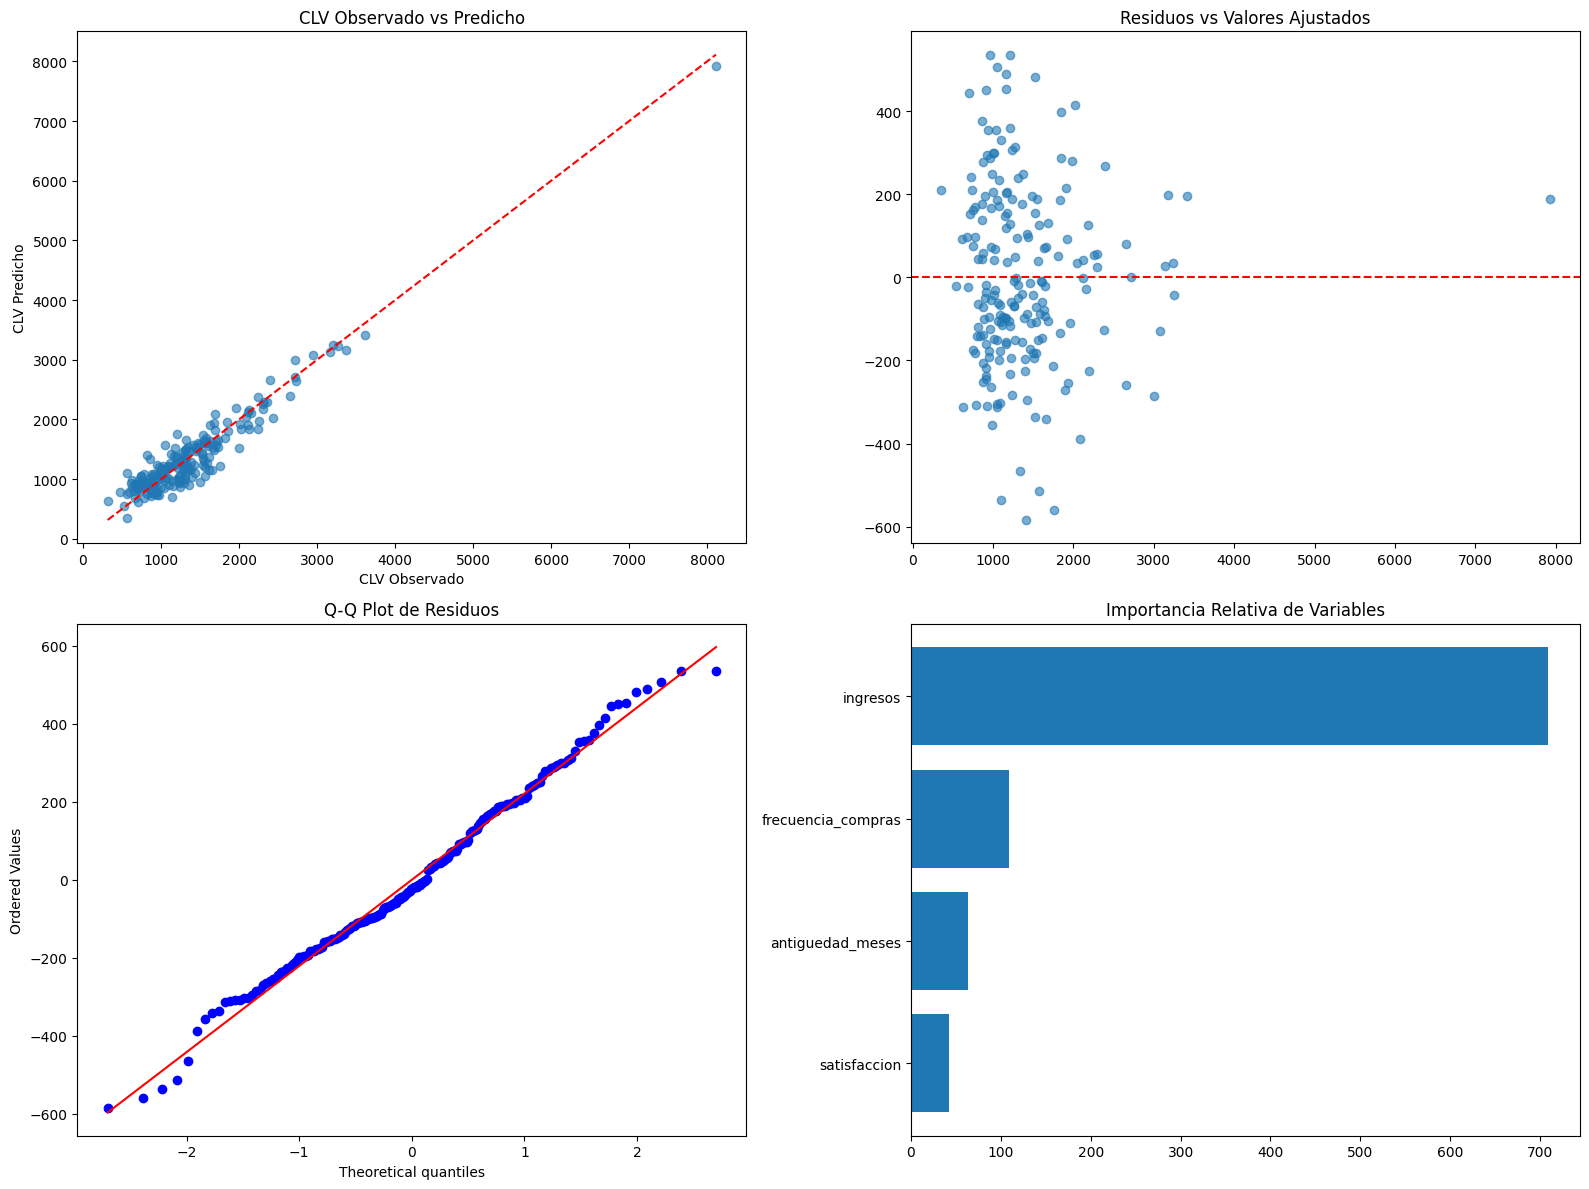


RESUMEN EJECUTIVO
R²: 0.916
RMSE: $219
Supuestos cumplidos: 3 de 3

CLV predicho para cliente nuevo: $2374


In [2]:
# ============================================================
# DÍA 4 - MODELADO PREDICTIVO DE CLV CON REGRESIÓN LINEAL
# Archivo: modelado_predictivo_usando_regresion_lineal_dia4.ipynb
# ============================================================

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# ============================================================
# 1. GENERACIÓN DE DATOS
# ============================================================

np.random.seed(42)
n_clientes = 200

df = pd.DataFrame({
    'cliente_id': range(1, n_clientes + 1),
    'edad': np.random.normal(35, 10, n_clientes).clip(18, 70).astype(int),
    'ingresos': np.random.lognormal(10.5, 0.6, n_clientes).round(0),
    'frecuencia_compras': np.random.poisson(4, n_clientes),
    'antiguedad_meses': np.random.exponential(24, n_clientes).astype(int),
    'satisfaccion': np.random.normal(7.5, 1.2, n_clientes).clip(1, 10),
    'canal_adquisicion': np.random.choice(['Online', 'Tienda', 'App'], n_clientes)
})

# CLV con relación lineal verdadera
clv_base = (
    df['ingresos'] * 0.02 +
    df['frecuencia_compras'] * 50 +
    df['antiguedad_meses'] * 2 +
    df['satisfaccion'] * 30
)

# Ruido homocedástico
df['clv'] = clv_base + np.random.normal(0, clv_base.std() * 0.3, n_clientes)
df['clv'] = df['clv'].clip(0)

print("DATASET PARA MODELADO CLV")
print("=" * 30)
print(f"Clientes analizados: {len(df)}")
print(f"CLV promedio: ${df['clv'].mean():.0f}")
print(f"Rango CLV: ${df['clv'].min():.0f} - ${df['clv'].max():.0f}")

# ============================================================
# 2. ANÁLISIS EXPLORATORIO Y CORRELACIONES
# ============================================================

numeric_cols = [
    'edad', 'ingresos', 'frecuencia_compras',
    'antiguedad_meses', 'satisfaccion', 'clv'
]

correlaciones = df[numeric_cols].corr()['clv'].sort_values(ascending=False)

print("\nCORRELACIONES CON CLV:")
for var, corr in correlaciones.items():
    if var != 'clv':
        print(f"{var:20} | {corr:+.3f}")

# ============================================================
# 3. MODELO 1: REGRESIÓN SIMPLE
# ============================================================

modelo1 = smf.ols('clv ~ ingresos', data=df).fit()

y_pred1 = modelo1.predict(df)
r2_1 = r2_score(df['clv'], y_pred1)
rmse_1 = np.sqrt(mean_squared_error(df['clv'], y_pred1))

print("\nMODELO 1: CLV ~ INGRESOS")
print("=" * 30)
print(f"R²: {r2_1:.4f}")
print(f"RMSE: ${rmse_1:.0f}")

# ============================================================
# 4. MODELO 2: REGRESIÓN MÚLTIPLE
# ============================================================

modelo2 = smf.ols(
    'clv ~ ingresos + frecuencia_compras + antiguedad_meses + satisfaccion',
    data=df
).fit()

y_pred2 = modelo2.predict(df)
r2_2 = r2_score(df['clv'], y_pred2)
rmse_2 = np.sqrt(mean_squared_error(df['clv'], y_pred2))

print("\nMODELO 2: REGRESIÓN MÚLTIPLE")
print("=" * 35)
print(modelo2.summary().tables[1])

print(f"R²: {r2_2:.4f}")
print(f"RMSE: ${rmse_2:.0f}")
print(f"AIC: {modelo2.aic:.1f}")

print("\nMEJORA RESPECTO AL MODELO SIMPLE")
print(f"Mejora R²: {((r2_2 - r2_1)/r2_1)*100:.1f}%")
print(f"Mejora RMSE: {((rmse_1 - rmse_2)/rmse_1)*100:.1f}%")

# ============================================================
# 5. INTERPRETACIÓN DE COEFICIENTES
# ============================================================

print("\nINTERPRETACIÓN DE COEFICIENTES")
print("=" * 40)

coef = modelo2.params
pvals = modelo2.pvalues
conf_int = modelo2.conf_int()

for var in ['ingresos', 'frecuencia_compras', 'antiguedad_meses', 'satisfaccion']:
    print(f"\n{var.upper()}")
    print(f"Coeficiente: {coef[var]:.4f}")
    print(f"IC 95%: ({conf_int.loc[var,0]:.4f}, {conf_int.loc[var,1]:.4f})")
    print(f"Significativo: {'Sí' if pvals[var] < 0.05 else 'No'} (p={pvals[var]:.4f})")

# ============================================================
# 6. VALIDACIÓN DE SUPUESTOS
# ============================================================

residuos = modelo2.resid
ajustados = modelo2.fittedvalues

print("\nVALIDACIÓN DE SUPUESTOS")
print("=" * 30)

# Normalidad
stat, p_shapiro = stats.shapiro(residuos)
print(f"Normalidad (Shapiro): {'Sí' if p_shapiro > 0.05 else 'No'} (p={p_shapiro:.4f})")

# Homocedasticidad
bp = het_breuschpagan(residuos, modelo2.model.exog)
print(f"Homocedasticidad (BP): {'Sí' if bp[1] > 0.05 else 'No'} (p={bp[1]:.4f})")

# Independencia
dw = durbin_watson(residuos)
print(f"Durbin-Watson: {dw:.3f} (ideal ≈ 2)")

# Multicolinealidad (VIF)
X = df[['ingresos', 'frecuencia_compras', 'antiguedad_meses', 'satisfaccion']]
X_const = add_constant(X)

vif = pd.DataFrame({
    'Variable': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})

vif = vif[vif['Variable'] != 'const']

print("\nVIF (Multicolinealidad):")
for _, r in vif.iterrows():
    estado = "PROBLEMA" if r['VIF'] > 5 else "OK"
    print(f"{r['Variable']:20} | VIF={r['VIF']:.2f} | {estado}")

# ============================================================
# 7. VISUALIZACIONES
# ============================================================

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Observado vs Predicho
ax1.scatter(df['clv'], y_pred2, alpha=0.6)
ax1.plot([df['clv'].min(), df['clv'].max()],
         [df['clv'].min(), df['clv'].max()], 'r--')
ax1.set_title('CLV Observado vs Predicho')
ax1.set_xlabel('CLV Observado')
ax1.set_ylabel('CLV Predicho')

# Residuos vs Ajustados
ax2.scatter(ajustados, residuos, alpha=0.6)
ax2.axhline(0, color='red', linestyle='--')
ax2.set_title('Residuos vs Valores Ajustados')

# QQ plot
stats.probplot(residuos, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot de Residuos')

# Importancia relativa
impacto = modelo2.params[1:] * X.std()
impacto = impacto.abs().sort_values()

ax4.barh(impacto.index, impacto.values)
ax4.set_title('Importancia Relativa de Variables')

plt.tight_layout()

# Guardar figura
plt.savefig(
    "resultados_modelado_clv_regresion_lineal_dia4.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

# ============================================================
# 8. RESUMEN EJECUTIVO Y PREDICCIÓN
# ============================================================

print("\nRESUMEN EJECUTIVO")
print("=" * 30)
print(f"R²: {r2_2:.3f}")
print(f"RMSE: ${rmse_2:.0f}")
print(f"Supuestos cumplidos: {sum([p_shapiro>0.05, bp[1]>0.05, abs(dw-2)<0.5])} de 3")

cliente_nuevo = pd.DataFrame({
    'ingresos': [80000],
    'frecuencia_compras': [8],
    'antiguedad_meses': [36],
    'satisfaccion': [8.5]
})

clv_pred = modelo2.predict(cliente_nuevo)[0]
print(f"\nCLV predicho para cliente nuevo: ${clv_pred:.0f}")

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
import scipy.stats as stats

# ==============================
# 1. DATASET ORIGINAL (simulado)
# ==============================
np.random.seed(42)
n = 200

df = pd.DataFrame({
    "ingresos": np.random.lognormal(mean=10, sigma=0.5, size=n),
    "frecuencia_compras": np.random.poisson(10, size=n),
    "edad": np.random.randint(18, 70, size=n),
    "antiguedad_meses": np.random.randint(1, 120, size=n),
    "satisfaccion": np.random.randint(1, 6, size=n)
})

df["clv"] = (
    0.02 * df["ingresos"]
    + 55 * df["frecuencia_compras"]
    + 2.7 * df["antiguedad_meses"]
    + 35 * df["satisfaccion"]
    + np.random.normal(0, 200, size=n)
)

# ==============================
# 2. ESTADÍSTICAS CLV
# ==============================
estadisticas_clv = pd.DataFrame({
    "metricas": ["Promedio", "Min", "Max"],
    "CLV": [df["clv"].mean(), df["clv"].min(), df["clv"].max()]
})

# ==============================
# 3. CORRELACIONES
# ==============================
correlaciones = df.corr(numeric_only=True)[["clv"]].sort_values("clv", ascending=False)

# ==============================
# 4. MODELO SIMPLE
# ==============================
modelo_simple = smf.ols("clv ~ ingresos", data=df).fit()
rmse_simple = np.sqrt(np.mean(modelo_simple.resid ** 2))

metricas_simple = pd.DataFrame({
    "R2": [modelo_simple.rsquared],
    "RMSE": [rmse_simple]
})

# ==============================
# 5. MODELO MÚLTIPLE
# ==============================
modelo_multiple = smf.ols(
    "clv ~ ingresos + frecuencia_compras + antiguedad_meses + satisfaccion",
    data=df
).fit()

rmse_multiple = np.sqrt(np.mean(modelo_multiple.resid ** 2))

coeficientes = modelo_multiple.summary2().tables[1]

metricas_multiple = pd.DataFrame({
    "R2": [modelo_multiple.rsquared],
    "RMSE": [rmse_multiple],
    "AIC": [modelo_multiple.aic]
})

# ==============================
# 6. MEJORA DEL MODELO
# ==============================
mejora_modelo = pd.DataFrame({
    "Mejora_R2_%": [(modelo_multiple.rsquared - modelo_simple.rsquared) * 100],
    "Mejora_RMSE_%": [(1 - rmse_multiple / rmse_simple) * 100]
})

# ==============================
# 7. VALIDACIÓN DE SUPUESTOS
# ==============================
shapiro_p = stats.shapiro(modelo_multiple.resid).pvalue
bp_test = het_breuschpagan(
    modelo_multiple.resid,
    modelo_multiple.model.exog
)
dw = durbin_watson(modelo_multiple.resid)

validacion = pd.DataFrame({
    "Test": ["Shapiro-Wilk", "Breusch-Pagan", "Durbin-Watson"],
    "Valor": [shapiro_p, bp_test[1], dw]
})

# ==============================
# 8. VIF
# ==============================
X = modelo_multiple.model.exog
vif = pd.DataFrame({
    "Variable": modelo_multiple.model.exog_names,
    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})

# ==============================
# 9. PREDICCIÓN CLIENTE NUEVO
# ==============================
cliente_nuevo = pd.DataFrame({
    "ingresos": [90000],
    "frecuencia_compras": [12],
    "antiguedad_meses": [36],
    "satisfaccion": [4]
})

prediccion = pd.DataFrame({
    "CLV_predicho": modelo_multiple.predict(cliente_nuevo)
})

# ==============================
# 10. EXPORTAR A EXCEL
# ==============================
with pd.ExcelWriter(
    "modelado_predictivo_usando_regresion_lineal_dia4.xlsx",
    engine="openpyxl"
) as writer:

    df.to_excel(writer, sheet_name="dataset_original", index=False)
    estadisticas_clv.to_excel(writer, sheet_name="estadisticas_clv", index=False)
    correlaciones.to_excel(writer, sheet_name="correlaciones")
    metricas_simple.to_excel(writer, sheet_name="modelo_simple_metricas", index=False)
    coeficientes.to_excel(writer, sheet_name="modelo_multiple_coeficientes")
    metricas_multiple.to_excel(writer, sheet_name="modelo_multiple_metricas", index=False)
    mejora_modelo.to_excel(writer, sheet_name="mejora_modelo", index=False)
    validacion.to_excel(writer, sheet_name="validacion_supuestos", index=False)
    vif.to_excel(writer, sheet_name="vif_multicolinealidad", index=False)
    prediccion.to_excel(writer, sheet_name="prediccion_cliente_nuevo", index=False)

print("Archivo Excel generado correctamente.")

Archivo Excel generado correctamente.
